# Imports

In [1]:
import pandas as pd
import os
import pandas as pd
import pathlib as pl
import json
import lovely_tensors
from matplotlib import font_manager
import utils as ut
from importlib import reload
from icecream import ic
import eyekit_measures as ekm

2024-02-07 16:35:56.973 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`


# Setting folders and loading files

In [2]:
type_of_file_to_process = [
    "raw_asc",
    "processed_data",
][0]
file_idx = 0
trial_choice_idx = 0
plotting_checkboxes_single = ["Uncorrected Fixations", "Corrected Fixations", "Words", "Word boxes"]
algo_choice = [ut.ALGO_CHOICES[-3],ut.ALGO_CHOICES[-2]]
ic(algo_choice)

ic| algo_choice: ['DIST-Ensemble', 'Wisdom_of_Crowds_with_DIST']


['DIST-Ensemble', 'Wisdom_of_Crowds_with_DIST']

In [17]:
reload(ut)
os.environ["MPLCONFIGDIR"] = os.getcwd() + "/configs/"

AVAILABLE_FONTS = [x.name for x in font_manager.fontManager.ttflist]
DEFAULT_PLOT_FONT = "DejaVu Sans Mono"
EXAMPLES_FOLDER = "./testfiles/"
EXAMPLES_ASC_ZIP_FILENAME = "asc_files.zip"
OSF_DOWNLAOD_LINK = "https://osf.io/download/us97f/"
EXAMPLES_FOLDER_PATH = pl.Path(EXAMPLES_FOLDER)
DIST_MODELS_FOLDER = pl.Path("models")
classic_algos_cfg = ut.get_classic_cfg("algo_cfgs_all.json")
gradio_temp_unzipped_folder = pl.Path("unzipped")
PLOTS_FOLDER = pl.Path("plots")
TEMP_FIGURE_STIMULUS_PATH = PLOTS_FOLDER.joinpath("temp_matplotlib_plot_stimulus.png")
ut.make_folders(ut.TEMP_FOLDER, gradio_temp_unzipped_folder, PLOTS_FOLDER)
ut.download_example_ascs(EXAMPLES_FOLDER, EXAMPLES_ASC_ZIP_FILENAME, OSF_DOWNLAOD_LINK, EXAMPLES_FOLDER_PATH)
lovely_tensors.monkey_patch()
asc_files = list(EXAMPLES_FOLDER_PATH.glob("*.asc"))
preprocesse_files = list(EXAMPLES_FOLDER_PATH.glob("*.json"))
ic(asc_files)
ic(preprocesse_files)

ic| asc_files: [Path('testfiles/ABREV1.asc'),
                Path('testfiles/ABREV2.asc'),
                Path('testfiles/ABREV4.asc'),
                Path('testfiles/ABREV5.asc')]
ic| preprocesse_files: [Path('testfiles/ABREV13_trial_id_E1I21D0_trial.json')]


[Path('testfiles/ABREV13_trial_id_E1I21D0_trial.json')]

In [4]:
if type_of_file_to_process == "raw_asc":
    asc_file = asc_files[file_idx]
    ic(f"Chosen asc file is {asc_file}")
else:
    trial_file = preprocesse_files[file_idx]
    fix_file = pl.Path(str(trial_file).replace("_trial.json", "_fixations.csv"))
    ic(f"Chosen trial file is {trial_file}")
    ic(f"Chosen fixations file is {fix_file}")

ic| f"Chosen asc file is {asc_file}": 'Chosen asc file is testfiles\\ABREV1.asc'


# Pre-loading models

In [5]:
models_dict = ut.set_up_models(DIST_MODELS_FOLDER);

c:\Users\pvwor\mambaforge\envs\pt2\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


remove_compile_from_model not done since model.project Linear(in_features=3, out_features=256, bias=False) has no orig_mod
remove_compile_from_model not done since model.project Linear(in_features=3, out_features=256, bias=False) has no orig_mod
remove_compile_from_model not done since model.project Linear(in_features=3, out_features=256, bias=False) has no orig_mod
remove_compile_from_model not done since model.project Linear(in_features=3, out_features=256, bias=False) has no orig_mod
remove_compile_from_model not done since model.project Linear(in_features=3, out_features=256, bias=False) has no orig_mod
remove_compile_from_model not done since model.project Linear(in_features=3, out_features=256, bias=False) has no orig_mod
remove_compile_from_model not done since model.project Linear(in_features=3, out_features=256, bias=False) has no orig_mod
remove_compile_from_model not done since model.project Linear(in_features=3, out_features=256, bias=False) has no orig_mod


# Read in Data

In [6]:
if type_of_file_to_process == "raw_asc":
    trial_choices_single_asc, trials_by_ids, lines, asc_file = ut.get_trials_list(asc_file)
    ic(len(trial_choices_single_asc))
    trial_choice = trial_choices_single_asc[trial_choice_idx]
    trial = trials_by_ids[trial_choice]

    trial["plot_file"] = str(PLOTS_FOLDER.joinpath(f"{asc_file.stem}_{trial_choice}_2ndInput_chars_channel_sep.png"))
    trial["fname"] = str(asc_file.name).split(".")[0]
    fname = trial["fname"]
    df, dffix, trial = ut.trial_to_dfs(trial, lines, use_synctime=True)
else:
    with open(trial_file, "r") as f:
        trial = json.load(f)
    dffix = pd.read_csv(
        fix_file,
    )
    trial_choice = trial["trial_id"]
    trial["plot_file"] = str(PLOTS_FOLDER.joinpath(f"{trial_choice}_2ndInput_chars_channel_sep.png"))
    fname = trial_file.stem.split("_")[0]
    trial["fname"] = fname

ic| len(trial_choices_single_asc): 40


# Correct fixations via multiple algorithms

In [7]:
font, font_size, dpi, screen_res = ut.get_plot_props(trial, AVAILABLE_FONTS)

if "chars_list" in trial:
    chars_df = pd.DataFrame(trial["chars_list"])
    trial["chars_df"] = chars_df.to_dict()
    trial["y_char_unique"] = list(chars_df.char_y_center.sort_values().unique())
if algo_choice is not None and ("chars_list" in trial or "words_list" in trial):
    dffix, _ = ut.correct_df(
        dffix,
        algo_choice,
        trial,
        is_outside_of_streamlit=True,
        classic_algos_cfg=classic_algos_cfg,
        models_dict=models_dict,
    )

Applying correction algorithms:   0%|          | 0/2 [00:00<?, ?it/s]

save_path for im combo is plots\ABREV1_E3I11D0_2ndInput_chars_channel_sep_chars_channel_sep.png
save_path for im combo is plots\ABREV1_E3I11D0_2ndInput_chars_channel_sep_chars_channel_sep.png


c:\Users\pvwor\mambaforge\envs\pt2\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


save_path for im combo is plots\ABREV1_E3I11D0_2ndInput_chars_channel_sep_chars_channel_sep.png


In [8]:
dffix.to_csv(f"results/{fname}_{trial_choice}",index=False)

# Plot results

In [9]:
ut.plotly_plot_with_image(
                    dffix,
                    trial,
                    to_plot_list=plotting_checkboxes_single,
                    algo_choice=algo_choice,
                    scale_factor=0.5,
                )

In [10]:
ut.plot_y_corr(dffix, algo_choice, margin=dict(t=10, l=50, r=10, b=50))

# Data analysis

In [11]:

if "Consolas" in AVAILABLE_FONTS:
    font_index = AVAILABLE_FONTS.index("Consolas")
elif "Courier New" in AVAILABLE_FONTS:
    font_index = AVAILABLE_FONTS.index("Courier New")
elif "DejaVu Sans Mono" in AVAILABLE_FONTS:
    font_index = AVAILABLE_FONTS.index("DejaVu Sans Mono")
else:
    font_index = 0

## Eyekit based analysis

In [12]:
font_face = AVAILABLE_FONTS[font_index]
algo_choice_single_asc_eyekit = algo_choice[0]
use_corrected_fixations = True
(
    y_diff,
    x_txt_start,
    y_txt_start,
    _,
    _,
    line_height,
) = ut.add_default_font_and_character_props_to_state(trial)
font_size = ut.set_font_from_chars_list(trial)

In [13]:

fixation_sequence, textblock, screen_size = ekm.get_fix_seq_and_text_block(
    dffix,
    trial,
    x_txt_start=x_txt_start,
    y_txt_start=y_txt_start,
    font_face=font_face,
    font_size=font_size,
    line_height=line_height,
    use_corrected_fixations=use_corrected_fixations,
    correction_algo=algo_choice_single_asc_eyekit,
)

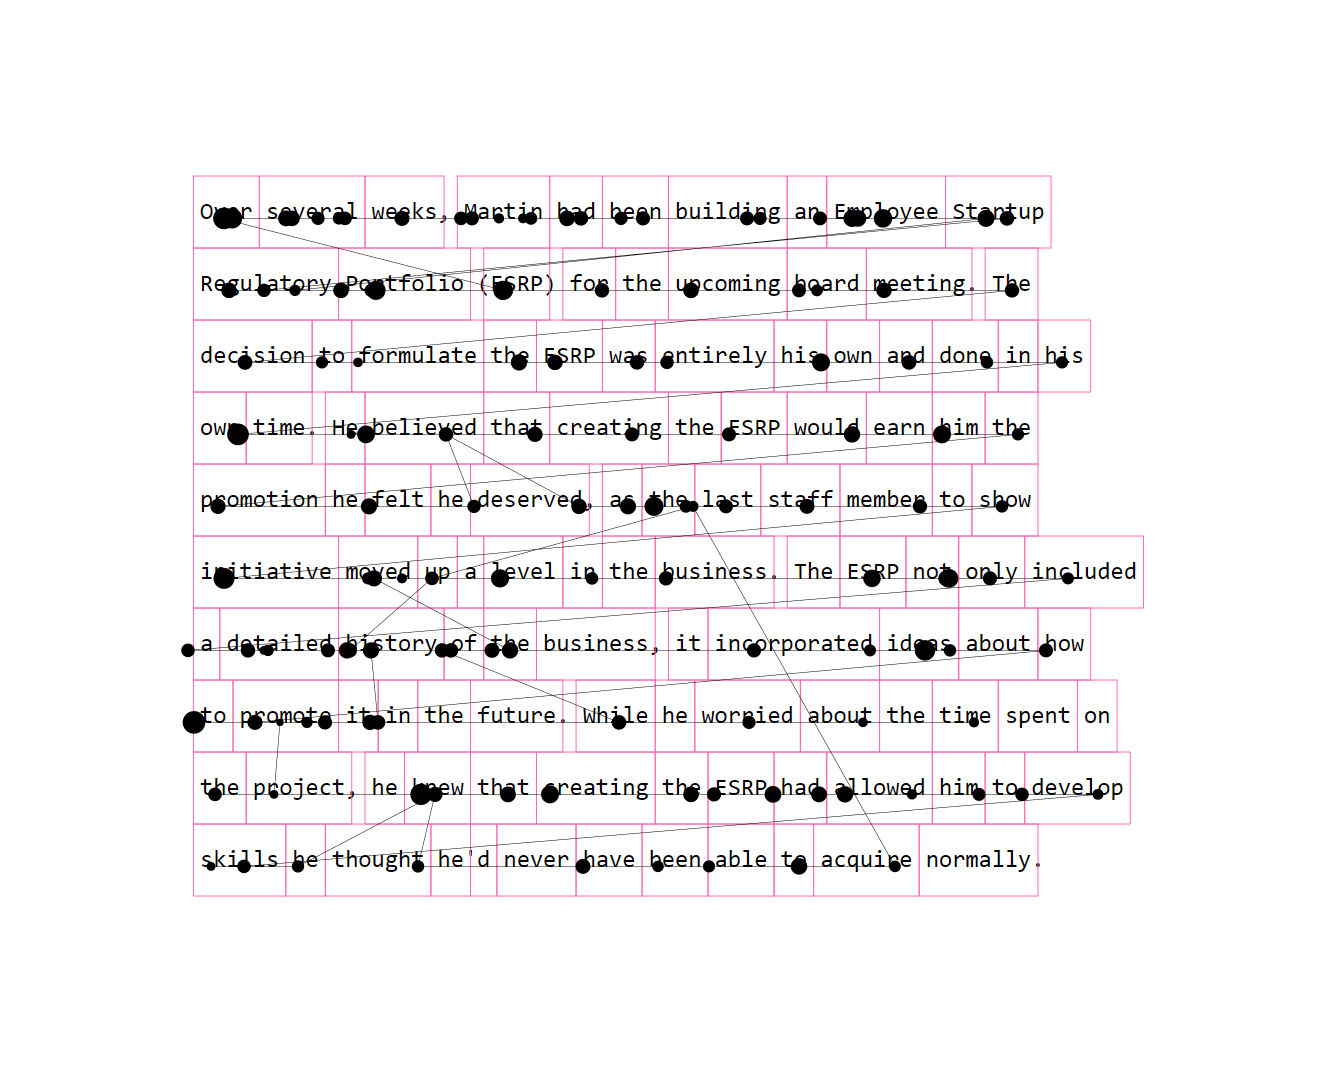

In [14]:
eyekitplot_img = ekm.eyekit_plot(textblock, fixation_sequence, screen_size)
eyekitplot_img

In [15]:

word_measures_df, character_measures_df = ekm.get_eyekit_measures(
    textblock, fixation_sequence, get_char_measures=False
)
word_measures_df

,word_number,word,number_of_fixations,initial_fixation_duration,first_of_many_duration,total_fixation_duration,gaze_duration,go_past_duration,second_pass_duration,initial_landing_position,initial_landing_distance,landing_distances,number_of_regressions_in
0,0,Over,3,372,372.0,852,372,372,324,2.0,24.000000,"[24.0, 32.0, 21.0]",2
1,1,several,5,137,137.0,793,137,797,336,4.0,52.023438,"[52.0234375, 26.0234375, 79.0234375, 20.023437...",1
2,2,weeks,1,179,NaN,179,179,179,0,3.0,30.460938,[30.4609375],0
3,3,Martin,5,155,155.0,587,302,302,128,1.0,8.093750,"[8.09375, 67.09375, 35.09375, 59.09375]",0
4,4,had,2,193,193.0,358,193,698,165,1.0,10.726562,"[10.7265625, 24.7265625]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,114,been,1,104,NaN,104,104,104,0,1.0,9.359375,[9.359375],0
115,115,able,1,116,NaN,116,116,220,0,NaN,NaN,[],0
116,116,to,1,215,NaN,215,215,215,0,2.0,18.406250,[18.40625],0
117,117,acquire,1,106,NaN,106,106,1107,0,6.0,74.820312,[74.8203125],0


## Analysis without Eyekit

In [19]:

own_word_measures = ut.get_all_measures(
    trial,
    dffix,
    prefix="word",
    use_corrected_fixations=True,
    correction_algo=algo_choice_single_asc_eyekit,
)
own_word_measures

,word_num,word,number_of_fixations,initial_fixation_duration,first_of_many_duration,total_fixation_duration,gaze_duration,go_past_duration,second_pass_duration,initial_landing_position,initial_landing_distance,landing_distances,number_of_regressions_in
word_index,,,,,,,,,,,,,
0,0,Over,3,373.0,373.0,855.0,373.0,373.0,325.0,2.0,24.5,"[24.5, 32.1, 21.2]",2
1,1,several,5,138.0,138.0,798.0,138.0,801.0,338.0,5.0,59.7,"[59.7, 33.5, 86.6, 27.8, 81.1]",1
2,2,weeks,1,180.0,NaN,180.0,180.0,180.0,0.0,3.0,40.3,[40.3],0
3,3,",",0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,[],0
4,4,Martin,5,156.0,156.0,592.0,304.0,304.0,129.0,1.0,18.7,"[18.7, 7.6, 77.7, 46.3, 70.4]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,122,able,1,117.0,NaN,117.0,117.0,222.0,0.0,1.0,9.3,[9.3],0
123,123,to,1,216.0,NaN,216.0,216.0,216.0,0.0,NaN,33.8,[33.8],0
124,124,acquire,1,107.0,NaN,107.0,107.0,1115.0,0.0,7.0,91.4,[91.4],0


In [23]:
%matplotlib inline

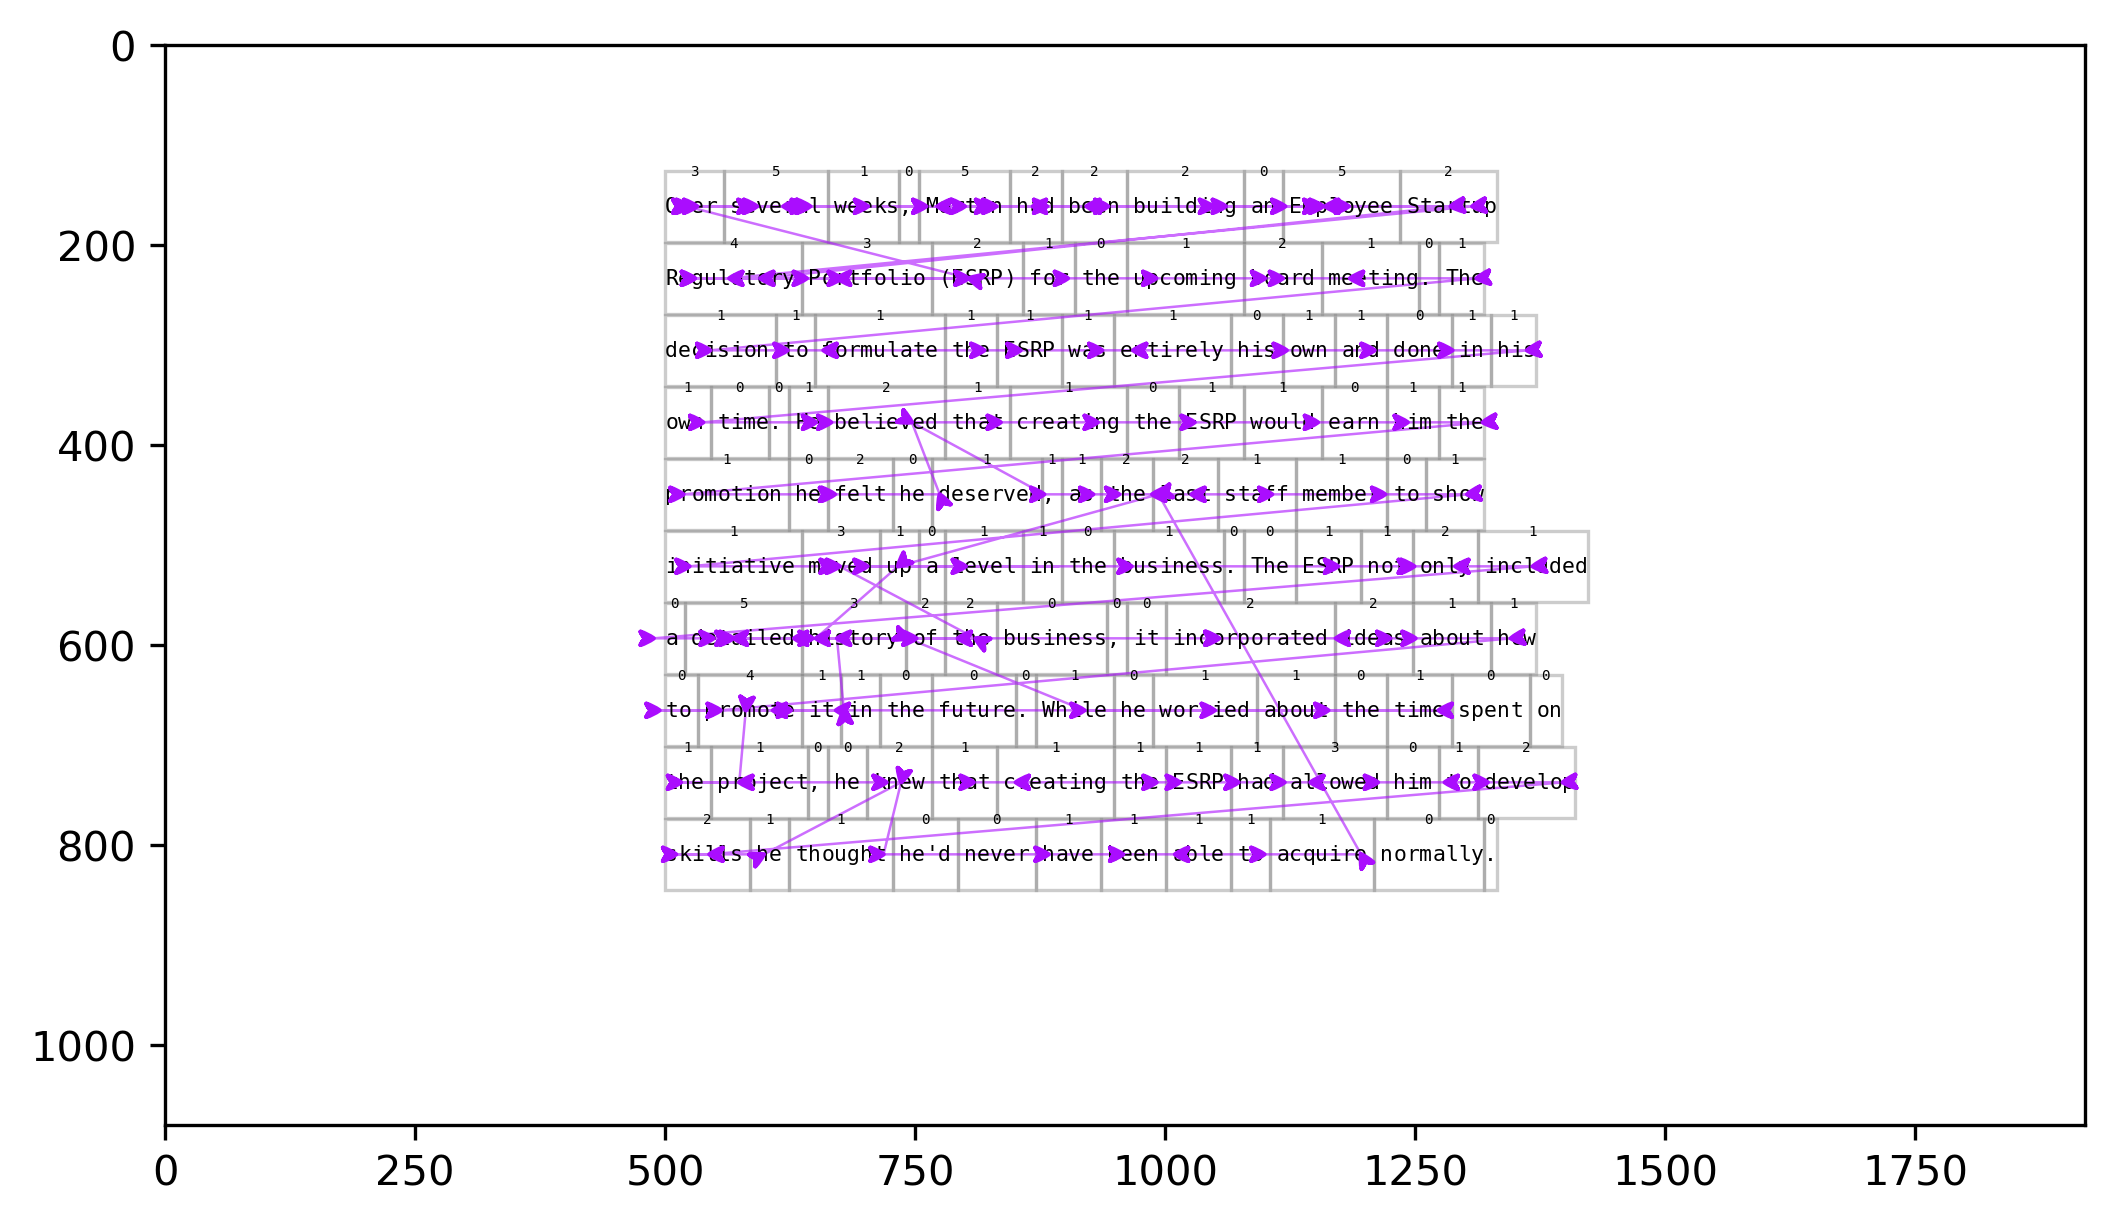

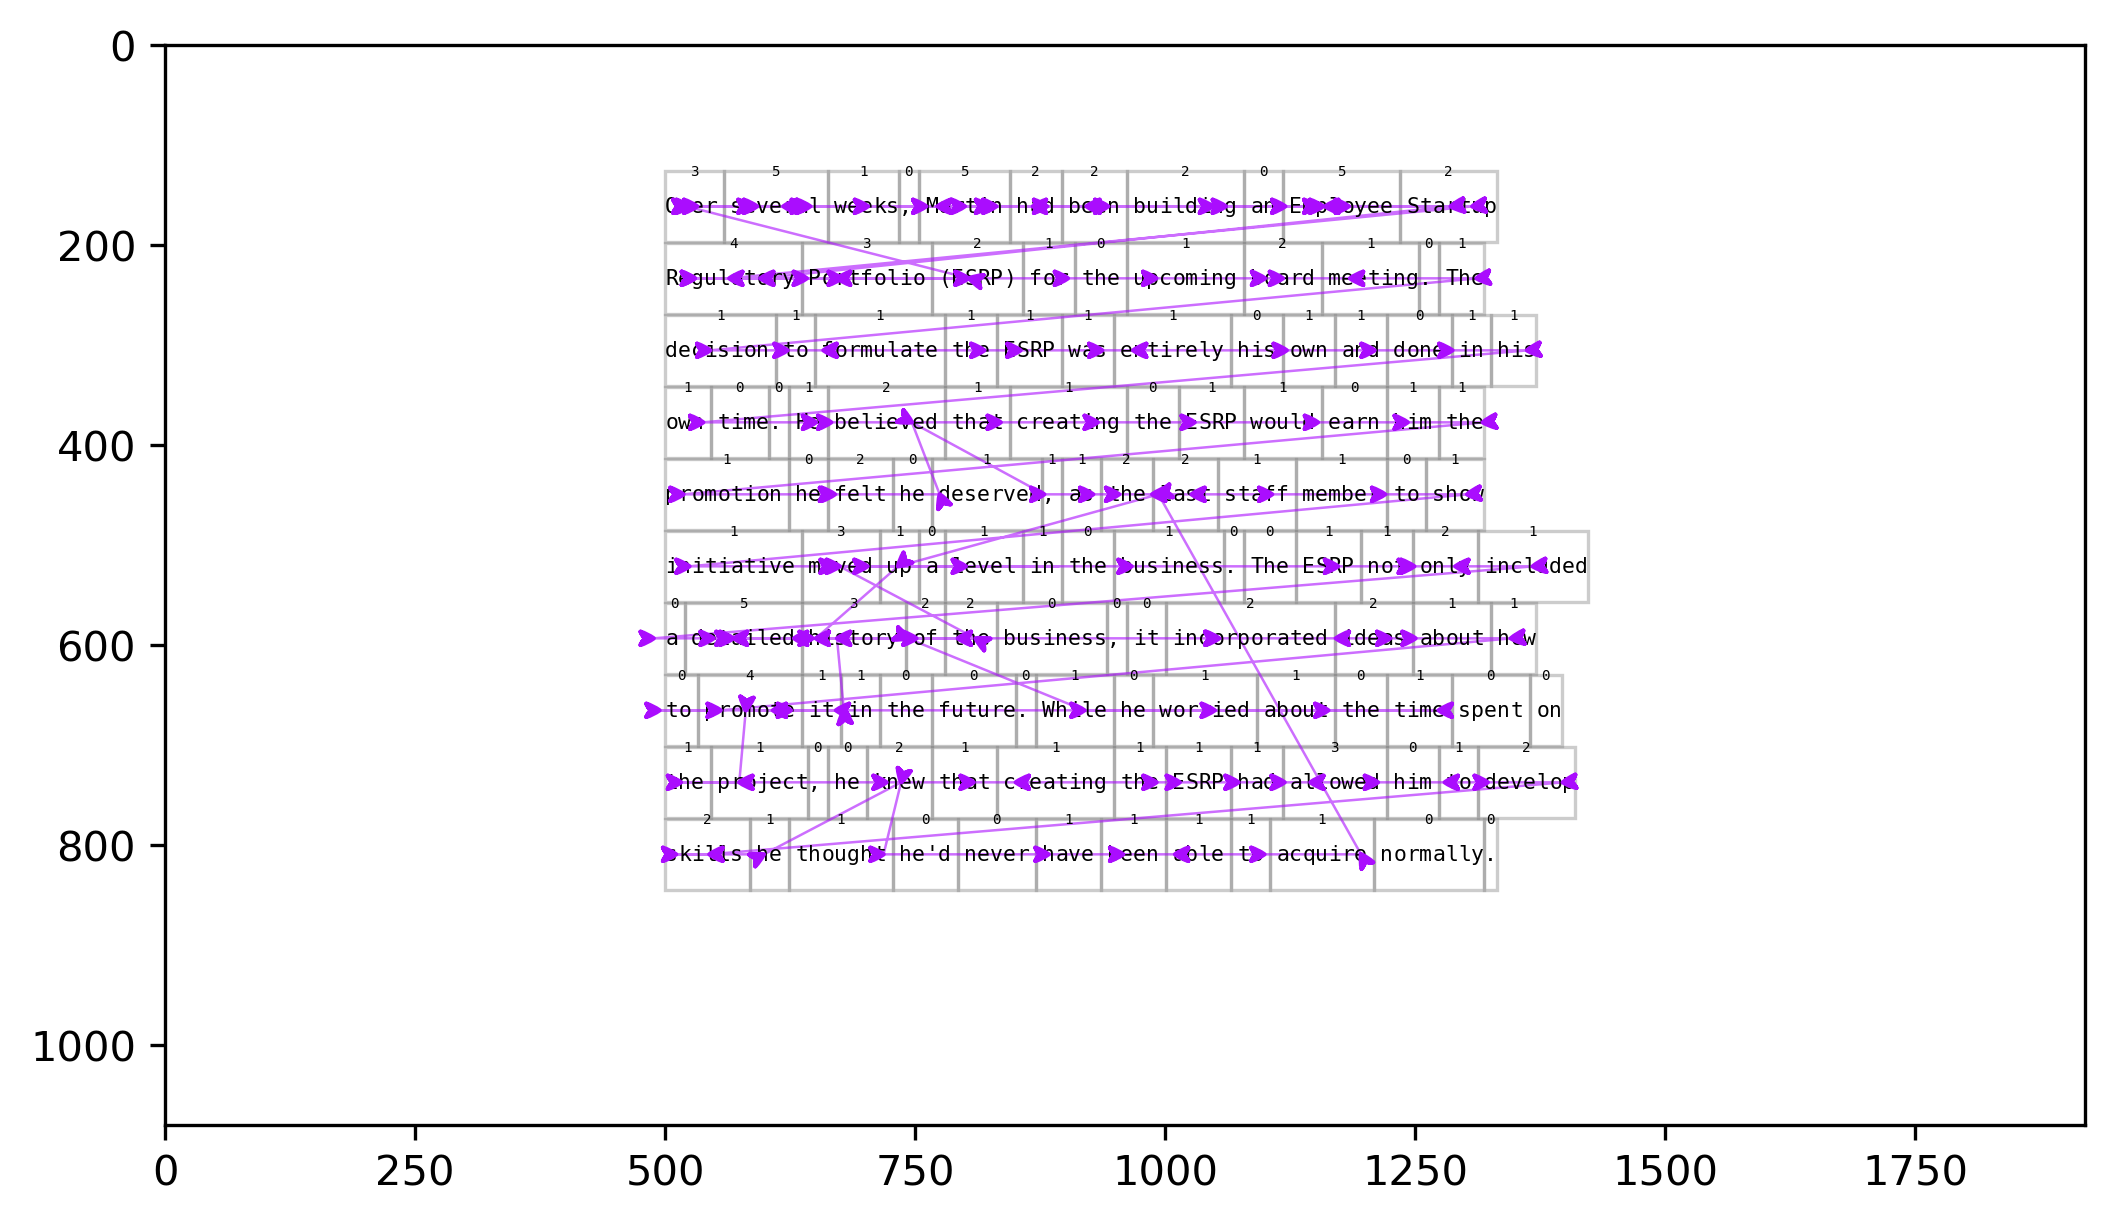

In [25]:
measure_words = list(ekm.MEASURES_DICT.keys())[0]
own_word_measures_fig, desired_width_in_pixels, desired_height_in_pixels = ut.matplotlib_plot_df(
    dffix,
    trial,
    algo_choice_single_asc_eyekit,
    stimulus_prefix="word",
    box_annotations=own_word_measures[measure_words],
    fix_to_plot=["Corrected Fixations"],
)